<a href="https://colab.research.google.com/github/FilipeCamello/lia1_2025_2/blob/main/C%C3%B3pia_de_Vis%C3%A3o_Computacional_Construindo_um_modelo_com_TensorFlow_Vegetables_Image_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color='Blue'>Projeto Ponta a Ponta - Construindo um Modelo com TensorFlow</font>

Construir um modelo de Intelig√™ncia Artificial capaz de classificar imagens de vegetais, considerando 15 categorias: Classes: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']. Dada uma nova imagem de uma dessas categorias o modelo deve ser capaz de classificar e indicar o que √© a imagem. <font color='red'>Lembrando: uma imagem √© uma matriz de pixels!</font>

Conhe√ßa o TensorFlow! -> https://www.tensorflow.org/

In [1]:
# Vers√£o da Linguagem Python
from platform import python_version
print('Vers√£o do Python neste Notebook:', python_version())

Vers√£o do Python neste Notebook: 3.12.11


In [2]:
# Instala o TF
#!pip install -q tensorflow==2.12
!pip install -q tensorflow

In [3]:
# Silencia mensagens do TF
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [4]:
# Imports
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
from skimage import io, color
import cv2
import zipfile
import os
from tensorflow.keras.utils import to_categorical

## Carregando os dados - mat√©ria prima

Vegetable image dataset:
https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset/data

In [5]:
# Importa o dataset vegetables
with zipfile.ZipFile('/content/vegetal.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')


In [6]:
# Carrega o dataset vegetables
def load_data(base_dir='dataset/Vegetable Images', img_size=(32, 32)):
    """
    Carrega dataset com estrutura:
    Dataset/Vegetable Images/
    ‚îú‚îÄ‚îÄ test/
    ‚îÇ   ‚îú‚îÄ‚îÄ class1/
    ‚îÇ   ‚îú‚îÄ‚îÄ class2/
    ‚îÇ   ‚îî‚îÄ‚îÄ ...
    ‚îú‚îÄ‚îÄ train/
    ‚îÇ   ‚îú‚îÄ‚îÄ class1/
    ‚îÇ   ‚îú‚îÄ‚îÄ class2/
    ‚îÇ   ‚îî‚îÄ‚îÄ ...
    ‚îî‚îÄ‚îÄ validation/
        ‚îú‚îÄ‚îÄ class1/
        ‚îú‚îÄ‚îÄ class2/
        ‚îî‚îÄ‚îÄ ...
    """

    # Definir caminhos
    train_dir = os.path.join(base_dir, 'train')
    test_dir = os.path.join(base_dir, 'test')
    val_dir = os.path.join(base_dir, 'validation')

    # Verificar se os diret√≥rios existem
    if not os.path.exists(train_dir):
        raise ValueError(f"Diret√≥rio de treino n√£o encontrado: {train_dir}")
    if not os.path.exists(test_dir):
        raise ValueError(f"Diret√≥rio de teste n√£o encontrado: {test_dir}")

    print("Carregando dataset...")

    # Fun√ß√£o auxiliar para carregar imagens de uma pasta
    def load_images_from_folder(folder_path):
        images = []
        labels = []
        class_names = []

        # Encontrar classes (pastas)
        classes = sorted([d for d in os.listdir(folder_path)
                         if os.path.isdir(os.path.join(folder_path, d))])

        for class_idx, class_name in enumerate(classes):
            class_path = os.path.join(folder_path, class_name)
            class_names.append(class_name)

            # Carregar imagens da classe
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    img_path = os.path.join(class_path, img_name)

                    # Ler e processar imagem
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR para RGB
                        img = cv2.resize(img, img_size)
                        images.append(img)
                        labels.append(class_idx)

        return np.array(images), np.array(labels), class_names

    # Carregar dados de treino
    print("Carregando dados de treino...")
    X_train, y_train, train_classes = load_images_from_folder(train_dir)

    # Carregar dados de teste
    print("Carregando dados de teste...")
    X_test, y_test, test_classes = load_images_from_folder(test_dir)

    # Verificar se as classes s√£o as mesmas
    if train_classes != test_classes:
        print("Aviso: Classes de treino e teste s√£o diferentes!")
        print(f"Treino: {train_classes}")
        print(f"Teste: {test_classes}")
        # Usar classes do treino como refer√™ncia
        class_names = train_classes
    else:
        class_names = train_classes

    # Carregar dados de valida√ß√£o (se existir)
    X_val, y_val = None, None
    if os.path.exists(val_dir):
        print("Carregando dados de valida√ß√£o...")
        X_val, y_val, val_classes = load_images_from_folder(val_dir)

    # Normalizar pixels para [0, 1]
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    if X_val is not None:
        X_val = X_val.astype('float32') / 255.0

    print("Dataset carregado com sucesso!")
    print(f"Treino: {X_train.shape[0]} imagens")
    print(f"Teste: {X_test.shape[0]} imagens")
    if X_val is not None:
        print(f"Valida√ß√£o: {X_val.shape[0]} imagens")
    print(f"Classes: {class_names}")
    print(f"N√∫mero de classes: {len(class_names)}")
    print(f"Tamanho das imagens: {img_size}")

    if X_val is not None:
        return (X_train, y_train), (X_test, y_test), (X_val, y_val), class_names
    else:
        return (X_train, y_train), (X_test, y_test), class_names

(imagens_treino, labels_treino), (imagens_teste, labels_teste), (imagens_val, labels_val), class_names = load_data()

Carregando dataset...
Carregando dados de treino...
Carregando dados de teste...
Carregando dados de valida√ß√£o...
Dataset carregado com sucesso!
Treino: 15000 imagens
Teste: 3000 imagens
Valida√ß√£o: 3000 imagens
Classes: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']
N√∫mero de classes: 15
Tamanho das imagens: (32, 32)


## Pr√©-processamento e Visualiza√ß√£o das imagens

In [7]:
# Fun√ß√£o para exibir as imagens
def visualiza_imagens(images, labels, classes):
    plt.figure(figsize = (10,10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[500*i], cmap = plt.cm.binary)
        plt.xlabel(class_names[labels[500*i]])
    plt.show()

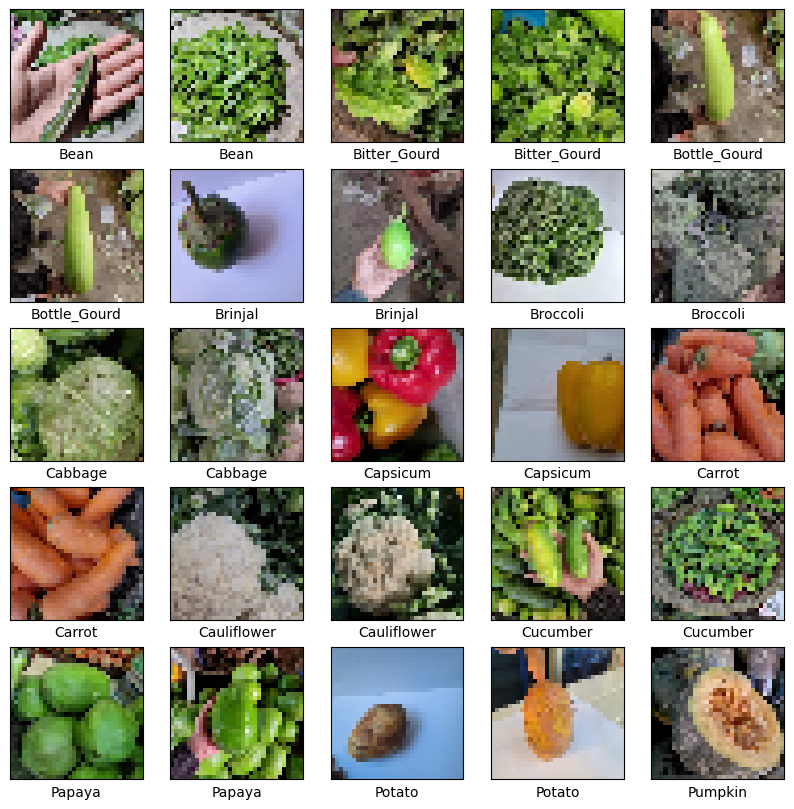

In [8]:
# Executa a fun√ß√£o
visualiza_imagens(imagens_treino, labels_treino, class_names)

## Constru√ß√£o do Modelo

In [9]:
# Arquitetura do Modelo -> Feature Learning

from tensorflow.keras import models, layers

modelo_lia = models.Sequential()

# Camada de entrada
modelo_lia.add(layers.Input(shape=(32, 32, 3)))

# Blocos convolucionais + pooling
modelo_lia.add(layers.Conv2D(32, (3, 3), activation='relu'))
modelo_lia.add(layers.MaxPooling2D((2, 2)))

modelo_lia.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelo_lia.add(layers.MaxPooling2D((2, 2)))

modelo_lia.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelo_lia.add(layers.MaxPooling2D((2, 2)))

In [10]:
# Adicionar camadas de classifica√ß√£o - Converte para um vetor - flatten
modelo_lia.add(layers.Flatten())
modelo_lia.add(layers.Dense(64, activation = 'relu'))
modelo_lia.add(layers.Dense(15, activation = 'softmax'))

In [11]:
# Sum√°rio do modelo
modelo_lia.summary()

Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d (Conv2D)                 ‚îÇ (None, 30, 30, 32)     ‚îÇ           896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d (MaxPooling2D)    ‚îÇ (None, 15, 15, 32)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_1 (Conv2D)               ‚îÇ (None, 13, 13, 64)     ‚îÇ        18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_1 (MaxPooling2D)  ‚îÇ (None, 6, 6, 64)       ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_2 (Conv2D)               ‚îÇ (None, 4, 4, 64)       ‚îÇ        36,928 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_2 (MaxPooling2D)  ‚îÇ (None, 2, 2, 64)       ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten (Flatten)               ‚îÇ (None, 256)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 64)             ‚îÇ        16,448 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 15)             ‚îÇ           975 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 73,743 (288.06 KB)

 Trainable params: 73,743 (288.06 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Compila√ß√£o do modelo
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
modelo_lia.compile(optimizer = 'adam',
                   loss = 'sparse_categorical_crossentropy',
                   metrics = ['accuracy'])

# adam - √© um algoritmo de aprendizagem tipo backpropagation!
# loss - fun√ß√£o de erro. Isso se resume a uma otimiza√ß√£o fun√ß√£o matem√°tica!
# metrics - medir o sucesso!

In [13]:
%%time
history = modelo_lia.fit(imagens_treino,
                         labels_treino,
                         epochs = 20,
                         validation_data = (imagens_teste, labels_teste))

Epoch 1/20
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 10ms/step - accuracy: 0.2973 - loss: 2.0273 - val_accuracy: 0.5787 - val_loss: 1.1983
Epoch 2/20
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 4ms/step - accuracy: 0.6237 - loss: 1.0982 - val_accuracy: 0.7087 - val_loss: 0.8116
Epoch 3/20
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 4ms/step - accuracy: 0.7502 - loss: 0.7511 - val_accuracy: 0.7403 - val_loss: 0.7374
Epoch 4/20
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 4ms/step - accuracy: 0.8052 - loss: 0.5791 - val_accuracy: 0.8293 - val_loss: 0.5021
Epoch 5/20
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 4ms/step - accuracy: 0.8452 - loss: 0.4784 - val_accuracy: 0.8443 - val_loss: 0.4914
Epoch 6/20
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 6ms/step - accuracy: 0.8784 - loss: 0.3846 - val_accuracy: 0.8467 - val_loss

## Avalia√ß√£o do modelo

In [14]:
# Avalia o modelo
erro_teste, acc_teste = modelo_lia.evaluate(imagens_teste, labels_teste, verbose = 2)

94/94 - 0s - 2ms/step - accuracy: 0.9103 - loss: 0.3151


In [15]:
print('\nAcur√°cia com dados de Teste:', acc_teste)


Acur√°cia com dados de Teste: 0.9103333353996277


94/94 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 5ms/step


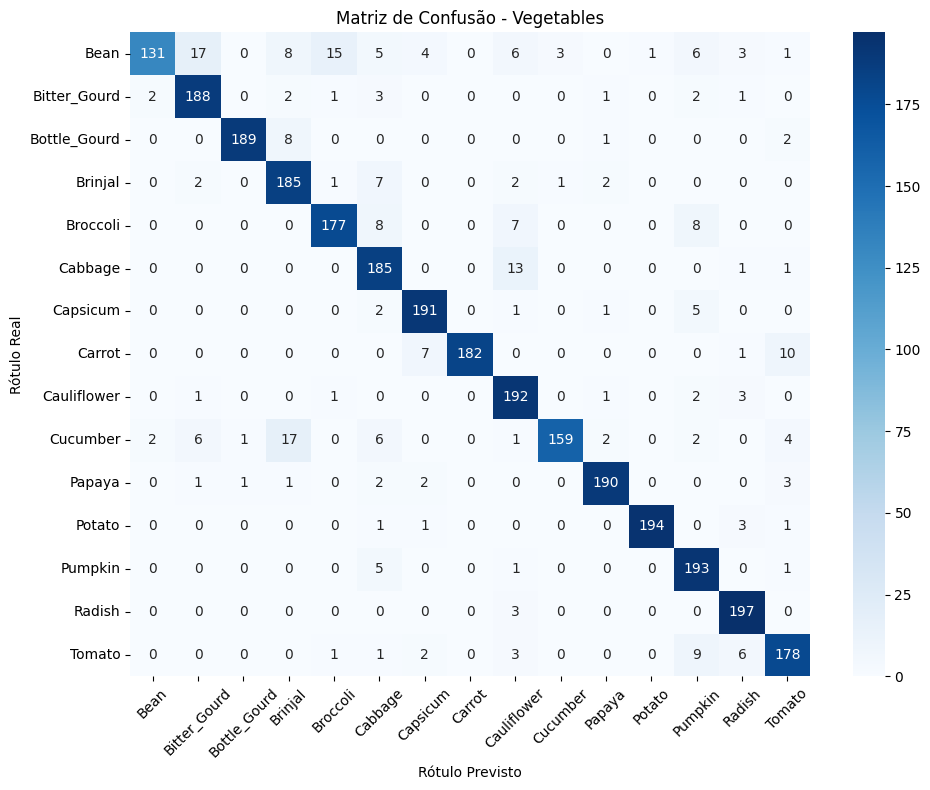

In [16]:
# Imprime a matriz de confus√£o
from sklearn.metrics import confusion_matrix

# Previs√£o do modelo
y_pred = modelo_lia.predict(imagens_teste)
y_pred_classes = np.argmax(y_pred, axis=1)

# Labels j√° est√£o no formato inteiro, ent√£o podemos us√°-las diretamente
y_true = labels_teste.flatten()  # Caso labels_teste tenha shape (10000, 1)

# Gera√ß√£o da matriz de confus√£o
cm = confusion_matrix(y_true, y_pred_classes)

# Impress√£o
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Matriz de Confus√£o - Vegetables')
plt.xlabel('R√≥tulo Previsto')
plt.ylabel('R√≥tulo Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Deploy do modelo

In [28]:
# Carrega uma nova imagem
nova_imagem = Image.open("/content/images (3).jpg")

In [29]:
# Dimens√µes da imagem (em pixels)
nova_imagem.size

(225, 225)

In [30]:
# Obt√©m largura e altura da imagem
largura = nova_imagem.width
altura = nova_imagem.height

In [31]:
print("A largura da imagem √©: ", largura)
print("A altura da imagem √©: ", altura)

A largura da imagem √©:  225
A altura da imagem √©:  225


In [32]:
# Redimensiona para 224x224 pixels
nova_imagem = nova_imagem.resize((32, 32))

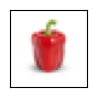

In [33]:
# Exibir a imagem
plt.figure(figsize = (1,1))
plt.imshow(nova_imagem)
plt.xticks([])
plt.yticks([])
plt.show()

In [34]:
# Converte a imagem para um array NumPy e normaliza
nova_imagem_array = np.array(nova_imagem) / 255.0

In [35]:
# Supondo que nova_imagem_array √© uma √∫nica imagem com shape (altura, largura, canais)
# Exemplo: (32, 32, 3) para uma imagem RGB 32x32

print("Shape original da imagem:", nova_imagem_array.shape)

# 1. Adicionar dimens√£o de batch (o modelo espera [batch_size, altura, largura, canais])
imagem_com_batch = np.expand_dims(nova_imagem_array, axis=0)
print("Shape com batch dimension:", imagem_com_batch.shape)

# 2. Verificar normaliza√ß√£o (deve estar entre 0 e 1)
if imagem_com_batch.max() > 1.0:
    imagem_com_batch = imagem_com_batch.astype('float32') / 255.0
    print("Imagem normalizada para [0, 1]")

# 3. Fazer a previs√£o para UMA √öNICA IMAGEM
previsoes = modelo_lia.predict(imagem_com_batch)

# 4. Obter resultados
classe_prevista = np.argmax(previsoes[0])  # [0] porque √© a primeira (e √∫nica) imagem do batch
confianca = previsoes[0][classe_prevista]

print(f"Classe predita: {classe_prevista}")
print(f"Confian√ßa: {confianca:.4f}")
print(f"Probabilidades: {previsoes[0]}")

Shape original da imagem: (32, 32, 3)
Shape com batch dimension: (1, 32, 32, 3)
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 30ms/step
Classe predita: 6
Confian√ßa: 1.0000
Probabilidades: [7.4138713e-26 1.0132113e-21 2.0931525e-16 7.3513283e-32 2.2485226e-23
 2.1853273e-24 9.9999380e-01 3.3083244e-10 6.1846711e-20 1.5665733e-18
 8.4211177e-15 6.0708956e-08 3.9679729e-15 4.6862106e-18 6.0317743e-06]


In [36]:
print(previsoes)

[[7.4138713e-26 1.0132113e-21 2.0931525e-16 7.3513283e-32 2.2485226e-23
  2.1853273e-24 9.9999380e-01 3.3083244e-10 6.1846711e-20 1.5665733e-18
  8.4211177e-15 6.0708956e-08 3.9679729e-15 4.6862106e-18 6.0317743e-06]]


In [37]:
# Obt√©m a classe com maior probabilidade e o nome da classe
classe_prevista = np.argmax(previsoes)
nome_classe_prevista = class_names[classe_prevista]
print("Probabilidades para primeira imagem:")
for i, prob in enumerate(previsoes[0]):
    print(f"{class_names[i]}: {prob:.4f}")

Probabilidades para primeira imagem:
Bean: 0.0000
Bitter_Gourd: 0.0000
Bottle_Gourd: 0.0000
Brinjal: 0.0000
Broccoli: 0.0000
Cabbage: 0.0000
Capsicum: 1.0000
Carrot: 0.0000
Cauliflower: 0.0000
Cucumber: 0.0000
Papaya: 0.0000
Potato: 0.0000
Pumpkin: 0.0000
Radish: 0.0000
Tomato: 0.0000


In [38]:
print("A nova imagem foi classificada como:", nome_classe_prevista)

A nova imagem foi classificada como: Capsicum


Se voc√™ chegou at√© aqui, parab√©ns! üéÜ üî•